                  Feature  Importance
13  sensor_measurement_11    0.454462
11   sensor_measurement_9    0.126009
6    sensor_measurement_4    0.078807
14  sensor_measurement_12    0.044934
9    sensor_measurement_7    0.036843
16  sensor_measurement_14    0.036393
17  sensor_measurement_15    0.031696
23  sensor_measurement_21    0.031209
4    sensor_measurement_2    0.027054
5    sensor_measurement_3    0.026745


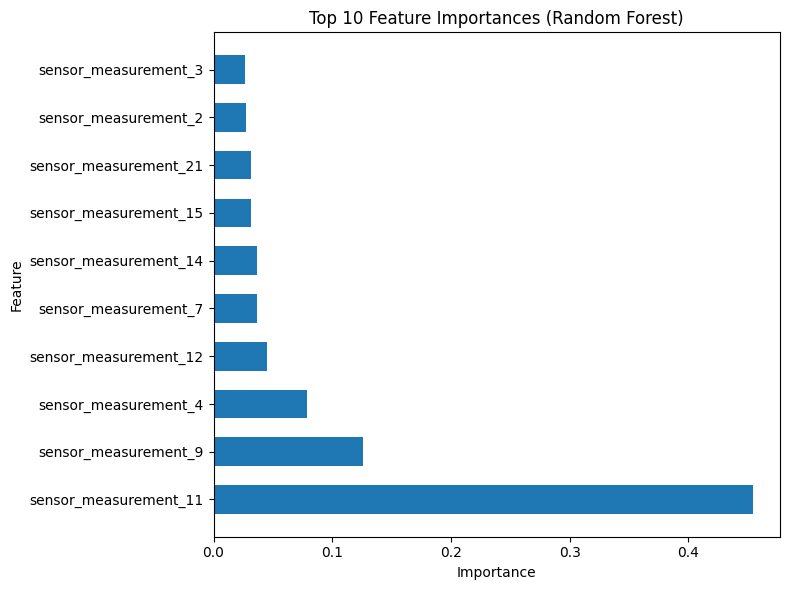

In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor


pd.set_option("display.max.columns", 100)
pd.set_option("display.width", 100)
df = pd.read_csv("../data/CMAPSS/train_FD001.txt", 
                 sep=r'\s+', 
                 header=None)

# print(df.isna().sum().sort_values(ascending=False))  # sum of missing per column we saw there are no missing values 

#add the columns
col_names = (
    ["unit_number", "time_in_cycles",
     "operational_setting_1", "operational_setting_2", "operational_setting_3"]
    + [f"sensor_measurement_{i}" for i in range(1, 22)])
df.columns = col_names
df["RUL"] = df.groupby("unit_number")["time_in_cycles"].transform(lambda s : s.max() - s )

#split data (we r creating train/test data based on unit_number)
train_df = df[df["unit_number"] <= 80]
test_df = df[df["unit_number"] > 80]

x_train = train_df.drop(columns=["RUL"])
y_train = train_df["RUL"]
x_test = test_df.drop(columns=["RUL"])
y_test = test_df["RUL"]

#now we will add features and targets; what features to generalize to attribute it to the RUL
#we want the features to be the sensor measurements, and we will drop the unit_number since its irrelevant, RUL since thats what we r trying to predict
#and time_cycles because we know already that it has an inverse relationship with the RUL. so we keep features for the train datasets, and targets for test dataset
x_train = x_train[["operational_setting_1", "operational_setting_2", "operational_setting_3"]
    + [f"sensor_measurement_{i}" for i in range(1, 22)]]
x_test = x_test[[     "operational_setting_1", "operational_setting_2", "operational_setting_3"]
    + [f"sensor_measurement_{i}" for i in range(1, 22)]]
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)


#we'll do a first baseline test using linear regression ------- LINEAR REGRESSION ----------------
regr = LinearRegression() 
regr.fit(x_train, y_train)
# print(f"{round(regr.score(x_test, y_test) * 100, 2

y_pred = regr.predict(x_test)
y_pred = np.maximum(y_pred, 0) #clipping y_pred so its above 0 cuz its RUL. and time can never be negative

# lets do exploratory data analysis on the y predictions
# # plotting y_pred against against y_test values in a scatter plot
# plt.figure(figsize=(6,6))
# plt.scatter(y_test, y_pred, alpha=0.3, s=10)  # alpha for transparency, s for smaller dots
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # red dashed diagonal
# plt.xlabel("True RUL")
# plt.ylabel("Predicted RUL")
# plt.title("Predicted vs True RUL")
# plt.grid(True)
# plt.show()


# now we can use evaluation metrics, MAE, RMSE to get deeper into how well the model is doing. 
MAE = round(mean_absolute_error(y_test, y_pred),2)
RMSE = round(root_mean_squared_error(y_test, y_pred), 2)
r2_score = regr.score(x_test, y_test)
# print(f"For Linear Regression. Mean Absolute Error is {MAE} cycles. Root Mean Squared Error is {RMSE} cycles. R^2 score is {r2_score}") 
#Mean Absolute Error is 38.66 cycles. Root Mean Squared Error is 53.14 cycles FOR LINEAR REGRESSION

#----------------LINEAR REGRESSION ^ ----------------------------

#random forests here-------------------------------------------------------------
#now we will use random forests to see what the evaluation metrics are 
random_f = RandomForestRegressor(n_estimators=100)
random_f.fit(x_train, y_train)
r2_score_rf = random_f.score(x_test, y_test)
y_pred_rf = random_f.predict(x_test)
MAE1 = mean_absolute_error(y_test, y_pred_rf)
RMSE1 = root_mean_squared_error(y_test, y_pred_rf)
# print(f"For Random Forest Regression: Mean Absolute Value: {round(MAE1,2)} cycles And Root Mean Squared Value: {round(RMSE1,2)} cycles. R^2 Score: {r2_score_rf}")

#For Random Forest Regression: Mean Absolute Value: 37.79 cycles And Root Mean Squared Value: 52.88 cycles. R^2 Score: 0.5343802961629154
#------------------RANDOM FORESTS ^ -------------------------------

#plot a table to show evaluation metrics side by side
result_evaluation = pd.DataFrame(
    {
        "Model": ["Linear Regression", "Random Forests"],
        "Features": ["Ops+Sensors", "Ops+Sensors"],
        "MAE" : [round(MAE,2), round(MAE1,2)],
        "RMSE" : [round(RMSE,2), round(RMSE1,2)],
        "R^2" : [round(r2_score,4), round(r2_score_rf,4)]
        
    }
)

#now we will calculate features importances to see which features are the most influential 
importances = random_f.feature_importances_
feature_names = ["operational_setting_1", "operational_setting_2", "operational_setting_3"] + [f"sensor_measurement_{i}" for i in range(1, 22)]
feature_importance_df = pd.DataFrame({'Feature' : feature_names, 'Importance' : importances}).sort_values('Importance', ascending=False)
top_10 = feature_importance_df.head(10)
print(top_10)
plt.figure(figsize=(8,6))
plt.barh(top_10["Feature"], top_10["Importance"], height=0.6)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# print(result_evaluation)
#                Model     Features    MAE   RMSE     R^2
# 0  Linear Regression  Ops+Sensors  38.66  53.14  0.5233
# 1     Random Forests  Ops+Sensors  36.47  51.23  0.5629

# plt.plot(x_test, y_pred, color='k')
# plt.show()

# sensors = ["sensor_measurement_7", "sensor_measurement_11", "sensor_measurement_12", "sensor_measurement_14"]
# engine_id = 3 
# subset = df[df.unit_number == engine_id]
# for sensor in sensors:
#     plt.plot(subset.time_in_cycles, subset[sensor], label=f"Sensor {sensor}")
# plt.xlabel("Cycle")
# plt.ylabel("Sensor")
# plt.legend()
# plt.show()

    


# print(df[df["unit_number"] == 23]) #checking RULS per engine number
# print(df.shape)
# print(df.info())